In [1]:
# Import libraries 
# Library for data inspection
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

# Library for system and image control
import os
import shutil
import cv2

# Library for wavelet extraction
import pywt

# Library for model training
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Library for model estimators
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Library for result matrix
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
# Define algorithm for CascadeClassifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [3]:
# Create function to crop the faces with clear, visible 2 eyes from the pictures 
def get_cropped_img_with_2_eyes(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
    for(x, y, w, h) in faces:
        roi_gray = img_gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        roi_color = img[y:y+h, x:x+w]
        if len(eyes) >= 2:
            return roi_color

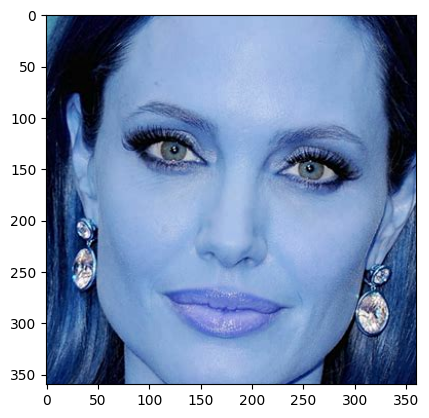

In [4]:
# Show the cropped face from on the images
test_img = get_cropped_img_with_2_eyes("Celebrity Faces Dataset/Angelina Jolie/002_8f8da10e.jpg")
plt.imshow(test_img)

In [5]:
# Setup for cropping images 
data_path = "./Celebrity Faces Dataset/"
cropped_data_path = "./cropped_images/"

img_dirs = []
for folder in os.scandir(data_path):
    if folder.is_dir():
        img_dirs.append(folder.path)

# Create the cropped image folder if not exist
if os.path.exists(cropped_data_path):
    shutil.rmtree(cropped_data_path)
os.mkdir(cropped_data_path)

In [6]:
# Crop images
cropped_img_dirs = []
celeb_name_dict = {}

for img_dir in img_dirs:
    count = 1;
    celeb_name = img_dir.split('/')[-1]

    celeb_name_dict[celeb_name] = []

    for imgs in os.scandir(img_dir):
        roi_color = get_cropped_img_with_2_eyes(imgs.path)
        if roi_color is not None:
            cropped_dir = cropped_data_path + celeb_name
            if not os.path.exists(cropped_dir):
                os.mkdir(cropped_dir)
                cropped_img_dirs.append(cropped_dir)
                print("Generating cropped folder for: ", celeb_name)
            # Save the cropped image in the folder
            cropped_img_name = celeb_name + str(count) + ".png"
            cropped_img_path = cropped_dir + "/" + cropped_img_name
            cv2.imwrite(cropped_img_path, roi_color)
            celeb_name_dict[celeb_name].append(cropped_img_path)
            count += 1

Generating cropped folder for:  Angelina Jolie
Generating cropped folder for:  Brad Pitt
Generating cropped folder for:  Denzel Washington
Generating cropped folder for:  Hugh Jackman
Generating cropped folder for:  Jennifer Lawrence
Generating cropped folder for:  Johnny Depp
Generating cropped folder for:  Kate Winslet
Generating cropped folder for:  Leonardo DiCaprio
Generating cropped folder for:  Megan Fox
Generating cropped folder for:  Natalie Portman
Generating cropped folder for:  Nicole Kidman
Generating cropped folder for:  Robert Downey Jr
Generating cropped folder for:  Sandra Bullock
Generating cropped folder for:  Scarlett Johansson
Generating cropped folder for:  Tom Cruise
Generating cropped folder for:  Tom Hanks
Generating cropped folder for:  Will Smith


In [7]:
# Define function to extract an image's wavelet
def w2d(img, mode = 'haar', level = 1):
    imArray = img
    
    # Convert image data to grayscale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    imArray = np.float32(imArray) / 255

    # Process and compute wavelet's coeffs
    coeffs = pywt.wavedec2(imArray, mode, level = level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0

    # Reconstruct the image
    imArray_H = pywt.waverec2(coeffs_H, mode) * 255
    imArray_H = np.uint8(imArray_H)

    return imArray_H


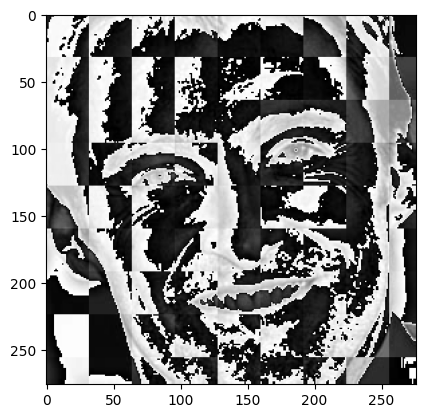

In [8]:
# Test the extract function with a sample image
test_img = cv2.imread("cropped_images/Hugh Jackman/Hugh Jackman11.png")
img_har = w2d(test_img, 'db1', 5)
plt.imshow(img_har, cmap = 'gray')

In [9]:
# Create a number dict for celeb name
celeb_num_dict = {}
count = 0
for celeb_name in celeb_name_dict.keys():
    celeb_num_dict[celeb_name] = count
    count += 1

# Print out the dict for number clarification
celeb_num_dict

{'Angelina Jolie': 0,
 'Brad Pitt': 1,
 'Denzel Washington': 2,
 'Hugh Jackman': 3,
 'Jennifer Lawrence': 4,
 'Johnny Depp': 5,
 'Kate Winslet': 6,
 'Leonardo DiCaprio': 7,
 'Megan Fox': 8,
 'Natalie Portman': 9,
 'Nicole Kidman': 10,
 'Robert Downey Jr': 11,
 'Sandra Bullock': 12,
 'Scarlett Johansson': 13,
 'Tom Cruise': 14,
 'Tom Hanks': 15,
 'Will Smith': 16}

In [10]:
# Set up the model
X = []
y = []
for celeb_name, train_imgs in celeb_name_dict.items():
    for train_img in train_imgs:
        img = cv2.imread(train_img)
        if img is None:
            continue
        scaled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32, 32))
        stacked_img = np.vstack((scaled_raw_img.reshape(32*32*3, 1), scaled_img_har.reshape(32*32, 1)))

        # Append to X and y for the model
        X.append(stacked_img)
        y.append(celeb_num_dict[celeb_name])

In [11]:
# Check for X and y
print("Length of X: ", len(X))
print("Length of each X element: ", len(X[0]), ". \nThe data within the first data of X: \n", X[0])

Length of X:  1376
Length of each X element:  4096 . 
The data within the first data of X: 
 [[249]
 [228]
 [226]
 ...
 [  3]
 [243]
 [227]]


In [12]:
# Reshape the data size
X = np.array(X).reshape(len(X), 4096).astype(float)
print("Shape of X: ", X.shape)

Shape of X:  (1376, 4096)


In [13]:
# Train the model
# Split data for training
X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state = 0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.5726744186046512

In [14]:
print("Length of the testing file: ", len(X_test))

Length of the testing file:  344


In [15]:
# Print the classification report
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.45      0.51        31
           1       0.31      0.45      0.37        11
           2       0.45      0.69      0.55        13
           3       0.57      0.44      0.50        18
           4       0.46      0.77      0.58        22
           5       0.38      0.18      0.24        17
           6       1.00      0.38      0.56        26
           7       0.85      0.63      0.72        27
           8       0.36      0.62      0.46        13
           9       0.57      0.44      0.50        18
          10       0.62      0.65      0.64        23
          11       0.44      0.47      0.45        15
          12       0.79      0.94      0.86        16
          13       0.48      0.71      0.57        38
          14       1.00      0.67      0.80        18
          15       0.75      0.67      0.71        18
          16       0.62      0.50      0.56        20

    accuracy              

In [16]:
# Model Params (taking recommendation from a tutorial
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [17]:
# GridSearch for best model 
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\kelly\.pyenv\pyenv-win\versions\3.11.0b4\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\kelly\.pyenv\pyenv-win\versions\3.11.0b4\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\kelly\.pyenv\pyenv-win\versions\3.11.0b4\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\kelly\.pyenv\pyenv-win\versions\3.11.0b4\Lib\site-pa

,model,best_score,best_params
0,svm,0.632733,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.302336,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.631781,{'logisticregression__C': 10}


In [18]:
# Show estimator result report
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=10, multi_class='auto',
                                     solver='liblinear'))])}

In [19]:
# Show the recall result for each estimator
print("Svm estimator result: ", best_estimators['svm'].score(X_test, y_test))
print("Random Forest estimator result: ", best_estimators['random_forest'].score(X_test, y_test))
print("Logistic Regression estimator result: ", best_estimators['logistic_regression'].score(X_test, y_test))

Svm estimator result:  0.6308139534883721
Random Forest estimator result:  0.32558139534883723
Logistic Regression estimator result:  0.6104651162790697


In [20]:
# Choose logistics regression as the best estimating method
best_method = best_estimators['logistic_regression']

In [21]:
# Show the result matrix
cm = confusion_matrix(y_test, best_method.predict(X_test))
cm

array([[16,  0,  0,  1,  1,  0,  0,  0,  4,  2,  1,  0,  1,  3,  1,  1,
         0],
       [ 0,  7,  1,  0,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0],
       [ 0,  1,  9,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  1,
         0],
       [ 0,  0,  0, 10,  0,  0,  0,  1,  0,  0,  0,  0,  1,  5,  0,  0,
         1],
       [ 0,  2,  1,  0, 10,  0,  1,  0,  1,  3,  3,  0,  0,  1,  0,  0,
         0],
       [ 2,  0,  2,  1,  2,  4,  1,  0,  0,  0,  2,  2,  0,  0,  0,  0,
         1],
       [ 0,  0,  0,  1,  3,  0, 13,  0,  1,  1,  3,  0,  0,  3,  0,  1,
         0],
       [ 1,  1,  0,  0,  0,  0,  1, 21,  0,  0,  0,  0,  1,  1,  0,  0,
         1],
       [ 3,  0,  0,  0,  0,  0,  0,  0,  8,  1,  0,  0,  1,  0,  0,  0,
         0],
       [ 1,  1,  0,  0,  2,  1,  0,  0,  1,  9,  1,  0,  0,  2,  0,  0,
         0],
       [ 1,  0,  0,  0,  0,  1,  0,  0,  0,  0, 19,  0,  0,  0,  1,  1,
         0],
       [ 0,  3,  2,  0,  1,  1,  0,  0,  0,  0,  0,  7,  0,  0,  

{'Angelina Jolie': 0,
 'Brad Pitt': 1,
 'Denzel Washington': 2,
 'Hugh Jackman': 3,
 'Jennifer Lawrence': 4,
 'Johnny Depp': 5,
 'Kate Winslet': 6,
 'Leonardo DiCaprio': 7,
 'Megan Fox': 8,
 'Natalie Portman': 9,
 'Nicole Kidman': 10,
 'Robert Downey Jr': 11,
 'Sandra Bullock': 12,
 'Scarlett Johansson': 13,
 'Tom Cruise': 14,
 'Tom Hanks': 15,
 'Will Smith': 16}

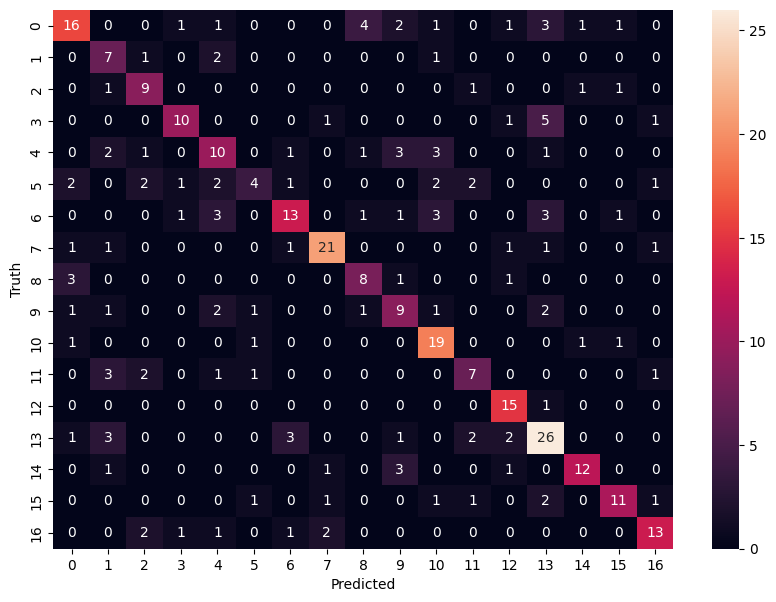

In [28]:
plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Print celeb_dict for reference
celeb_num_dict